# 任務
找出會再次使用這個服務的消費者輪廓以及其行為特徵

## 資料集

訂單建立日期, 訂單編號, 商品名稱, 交易金額, 分期期數, 分期利息, 分期總價(交易金額+分期利息), 有無轉由專人審核信用(布林值), 客戶 ID

## 資料觀察及前置處理

##### **可能會用到的模組**

In [1]:
import pandas as pd                                             # 資料處理及整合
import numpy as np                                              # 可能在整理數據時使用
import matplotlib.pyplot as plt                                 # 視覺化輔助工具
from mpl_toolkits.mplot3d import Axes3D                         # 用來畫出 3D 視覺圖
import seaborn as sns                                           # 主要視覺化工具
from sklearn.preprocessing import LabelEncoder                  # 用來將 Categorical Data 轉換成 Numeric Data
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # 要做 PCA 前資料要先做到歸一化或標準化
from sklearn.decomposition import PCA                           # 如果要做到視覺化可以使用 PCA 降維

#### **特徵選擇**: 

從上述資料看起來，我會認為較有效的資料為
* 交易金額
* 分期期數
* 分期利息
* 有無轉由專人審核信用
* 客戶 ID
* 商品名稱
  
    其中商品名稱可能需要進一步處理，例如轉換為商品類別等

##### 資料觀察 TIP:

1. 善用視覺化工具 (pair-plot, bar-plot, scatter-plot)
2. 觀察是否有 Outlier
3. 觀察是否有缺失值 (依據缺失值數量決定如何處理)
4. 注意資料型態 **(<font color='red'>機器學習模型只能接受數值型態資料</font>)**

這邊我使用的是來自 Kaggle 上經典的 titanic 資料集

* 我們在讀完資料後會先用 **head()** 去簡單看一下資料的 columns 確認有讀取到資料

In [2]:
df = pd.read_csv('./input/titanic.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* 概略觀察資料集的小工具: **info()**

    在這邊我們可以看到每個 column 的資料總數集型態以及<font color='red'>資料是否有缺失</font>
    
    可以看到這邊在 Age 及 Cabin 還有 Embarked 有缺失值，然後型態為 Object 的 columns 就是我們要處理的 column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* 概略觀察資料集的小工具: **describe()**

    這邊可以簡單地看一下數值型態 column 的分布狀態，沒什麼特別的

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### **缺失值處理**

1. 查看缺失值的數量
2. 假如數量非常少不影響總體，我們可以直接丟棄有缺失值的 row (方便省時)
3. 假如丟棄會影響的話就填補缺失值 (通常會使用 mean)

* 查看缺失值欄位及總數
  * isna() 用來鎖定缺失值
  * sum() 統整出數量

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* 首先處理 Age，他資料有點多，所以選擇用平均填入

* mean, median

In [6]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* 之後我們發現 Cabin 是艙位且大部分缺失，可知影響結果不大
* Embarked 是登船港口，所以也不影響結果
* 所以我們<font color='red'>**不會將所有 Categorical Data 都轉換成 Numeric Data，可以丟棄不必要的 Data**</font>

In [7]:
df.drop(['Cabin', 'Embarked'], axis='columns', inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500


##### 將我們認為沒用的 Categorical Data 丟棄 (這取決於你對資料 Domain-Knowledge 的了解程度)

In [8]:
df.drop(['Name', 'Ticket', 'PassengerId'], axis='columns', inplace=True)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


#### **特徵轉換**

##### 接下來將唯一的 Categorical Data 轉換 (Sex)

* Label Encoder & One-Hot Encoder
  * [關於 Label Encoder 和 One-Hot Encoder 的介紹](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)
  * [Label Encoder 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
  * [One-Hot Encoder 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

* 這邊我們使用 Label Encoder，接下來非常重要的一點
* <font color='red'>**如果你要做 PCA 或是 Scalar 以及 KMeans 等等操作的話，使用 One-Hot Encoder 會降低模型準確**</font>

In [9]:
le = LabelEncoder()

df['Sex'] = le.fit_transform(df['Sex'])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


* 用 Label Encoder 做到 One-Hot Encoder 的效果

In [ ]:
le = LabelEncoder()

dummies = pd.get_dummies(df['Sex'])

dummies.head()

In [ ]:
ohe_df = pd.concat([df, dummies], axis='columns')
ohe_df.drop('Sex', axis='columns', inplace=True)

ohe_df.head()

#### **資料前處理**

##### Scalar

* MinMax-Scalar & Standard-Scalar
  * [關於 MinMax-Scalar 和 Standard-Scalar 的介紹](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/)
  * [MinMax-Scalar 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
  * [Standard-Scalar 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* 要注意的是我們做標準化及 PCA 會用新的一個 DataFrame，因為我們要保留原始資料 

In [10]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [13]:
scalar = StandardScaler()

columns_to_scale = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
scaled_df = pd.DataFrame(scalar.fit_transform(df[columns_to_scale]), columns=columns_to_scale)

scaled_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337


##### PCA

* PCA 的重點是要降維，人類能夠看到的維度只有 3 維
* 因此我們至少要將 feature 降到 3 維以下才能夠做視覺化
* 這邊可以看出來就算降到 3 維，資料也還有差不多將近 75 % 的重要性

<AxesSubplot: >

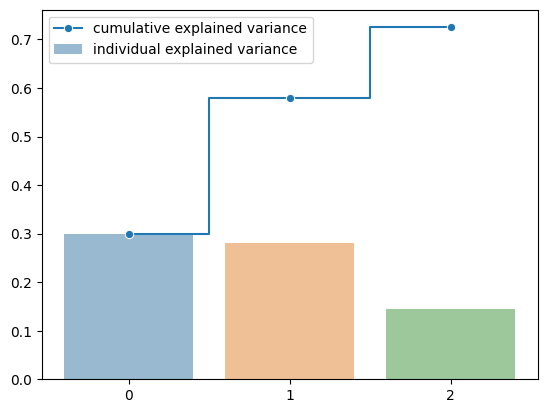

In [14]:
pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df[columns_to_scale]), columns=['col1', 'col2', 'col3'])

var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

sns.barplot(x=list(range(len(var_ratio))), y=var_ratio, alpha=0.5, label="individual explained variance")
sns.lineplot(x=list(range(len(var_ratio))), y=cum_var_ratio, marker='o', drawstyle="steps-mid", label="cumulative explained variance")

#### **最終處理完的資料**

In [15]:
pca_df.head()

,col1,col2,col3
0,-0.926296,-0.895259,0.557193
1,1.497933,1.339850,-0.728178
2,-0.449617,-0.505489,-1.599096
3,1.302467,1.103392,-0.826647
4,-1.310593,0.038177,0.295140


## 資料建模

* 因為 titanic 屬於有 labeled 的資料，所以並不是很適合分群用，因此這邊有一些是屬於監督式學習的模組不會被用到
    ```
    from sklearn.model_selection import train_test_split        # 將資料分為訓練模型用以及測試用
    from sklearn.model_selection import GridSearchCV            # 尋找最佳參數及模型
    from sklearn.svm import SVC                                 # 這兩個是之後可以再分類時使用的模型
    from sklearn.ensemble import RandomForestClassifier         # 同上
    ```

##### **可能會用到的模組**

In [38]:
from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer # 用來將參數結果視覺化
from sklearn.cluster import KMeans                                      # 分群用模型
from sklearn.cluster import MiniBatchKMeans                             # 這邊用 MiniBatch-KMeans 算是 KMeans 的優化版
from sklearn.cluster import AgglomerativeClustering                     # 這才是我們上個專案使用的分群方法，但不是和大量資料

##### **找出合適的分群數**

* 這邊直接使用 Silhouette Score 來看群數
* 每一群的 Silhouette Score 都要大於 Average Score
* 群數資料量的差異不能太大
* Silhouette Score 超過 0.7 代表很適合分群，0.5 ~ 0.7 是合理情況，小於 0.5 代表資料可能不太適合做分群
* k = 5 的結果看起來是勉強比較好的

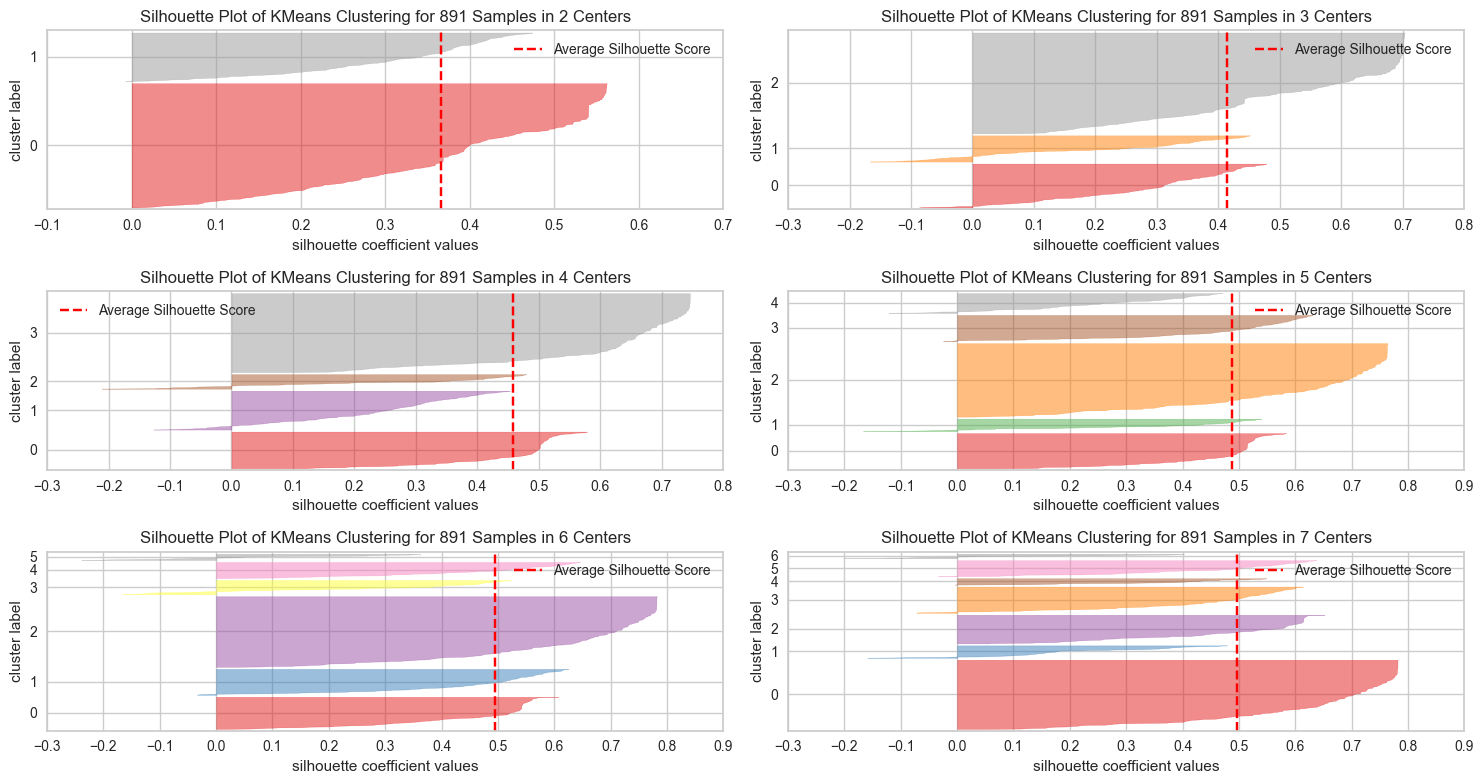

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
k_range = range(2, 8)

for i, ax in zip(k_range, axes.flatten()):
    silhouette_visualizer(KMeans(i, n_init='auto'), pca_df, ax=ax, show=False)

fig.tight_layout()
plt.show()

* 我們也可以簡單地看一下 Elbow Method
* 可以看出來手肘不太明顯，所以採用 Silhouette Score 的結果

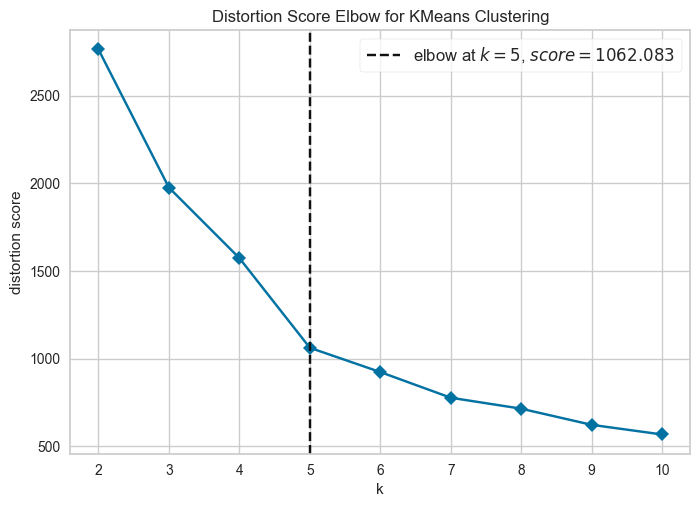

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
Elbow_M = KElbowVisualizer(KMeans(n_init='auto'), k=10, timings=False)
Elbow_M.fit(pca_df)
Elbow_M.show()

##### **使用分群模組**

* 先使用 K-Means
* 剛剛前面的結果分為 5 群較佳

In [44]:
km = KMeans(n_clusters=5, n_init='auto')

pca_df['cluster'] = km.fit_predict(pca_df)
df['cluster'] = km.fit_predict(pca_df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cluster,Clusters
0,0,3,1,22.0,1,0,7.2500,0,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,1,1
3,1,1,0,35.0,1,0,53.1000,2,0
4,0,3,1,35.0,0,0,8.0500,0,3


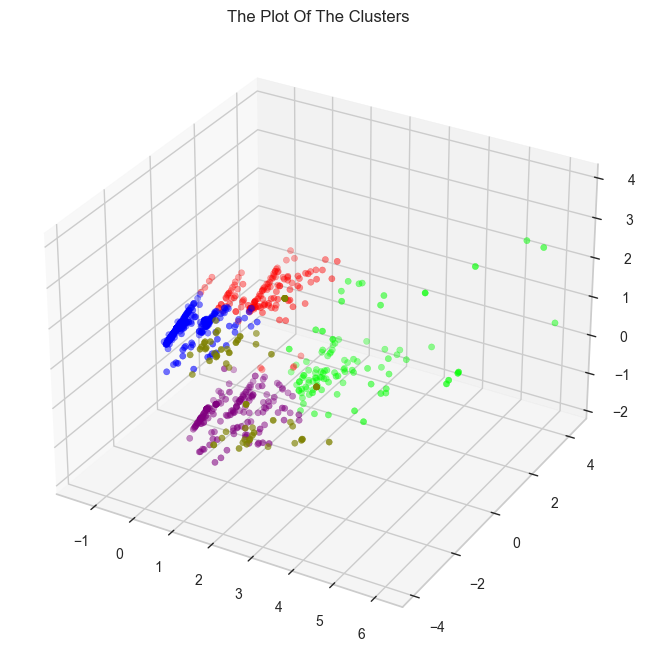

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection='3d')

ax.scatter(xs=pca_df['col1'], ys=pca_df['col2'], zs=pca_df['col3'], c=pca_df["cluster"], marker='o', cmap=plt.get_cmap("brg"))
ax.set_title("The Plot Of The Clusters")

plt.show()

* 這邊用 Mini Batch KMeans
* 它的優點是增快了 KMeans 的速度，但降低一點精度
* 但是在資料量大時可以忽略不計，所以還是挺實用的
* 這邊要注意的是 **batch_size**，如果資料量大的話可以將它增加，會運算比較快
* [Mini Batch KMeans 官方文件](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means)

In [46]:
mini_km = MiniBatchKMeans(n_init='auto', n_clusters=5, batch_size=100)

pca_df['cluster'] = mini_km.fit_predict(pca_df)
df['cluster'] = mini_km.fit_predict(pca_df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cluster,Clusters
0,0,3,1,22.0,1,0,7.2500,0,3
1,1,1,0,38.0,1,0,71.2833,1,0
2,1,3,0,26.0,0,0,7.9250,3,1
3,1,1,0,35.0,1,0,53.1000,1,0
4,0,3,1,35.0,0,0,8.0500,0,3


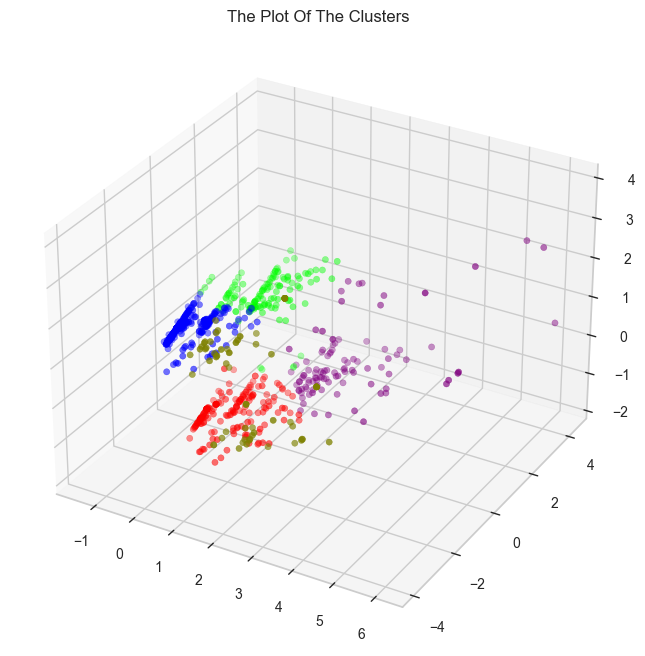

In [47]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection='3d')

ax.scatter(xs=pca_df['col1'], ys=pca_df['col2'], zs=pca_df['col3'], c=pca_df["cluster"], marker='o', cmap=plt.get_cmap("brg"))
ax.set_title("The Plot Of The Clusters")

plt.show()

* 最後這個是 Agglomerative Cluster
* 是我們上次使用的分類模型，但不太適合用在大量資料上

In [48]:
ac = AgglomerativeClustering(n_clusters=5)

pca_df["Clusters"] = ac.fit_predict(pca_df)
df["Clusters"]= ac.fit_predict(pca_df)

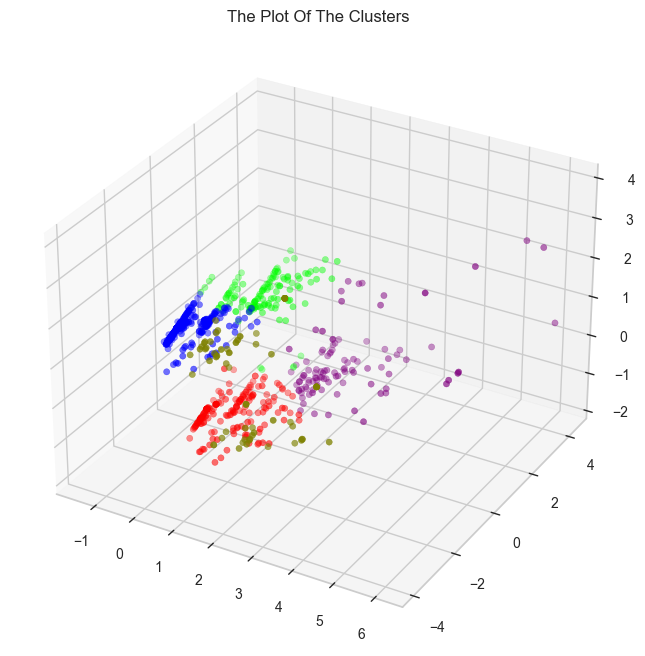

In [49]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection='3d')

ax.scatter(xs=pca_df['col1'], ys=pca_df['col2'], zs=pca_df['col3'], c=pca_df["cluster"], marker='o', cmap=plt.get_cmap("brg"))
ax.set_title("The Plot Of The Clusters")

plt.show()

## 分析結果

* 這邊就是分析的部分，我就不多加描述，你可以照著實際情況去做圖表

Text(0.5, 1.0, 'Distribution Of The Clusters')

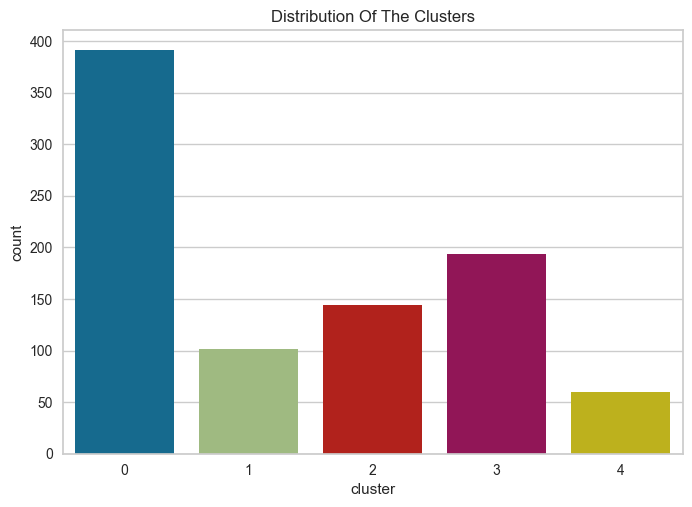

In [50]:
sns.countplot(x=df["cluster"]).set_title("Distribution Of The Clusters")

## 結論

* 在這邊我主要重點是在 PCA 以及分類模型的使用，我會建議你用 Mini Batch KMeans
* 如果你有碰到 Pandas 運用上的困難
* 或是圖表問題的話可以再提出
* 機器學習模型如果能力不足以處理的話我會再考慮使用深度學習
* 第二題的話之後再處理唄